In [16]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import layers as L

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns


In [4]:
df = pd.read_csv("../data/people_data.csv")
df = df.drop("img_name",axis=1)
df["pixels"] = df["pixels"].apply(lambda x: np.array(x.split(),dtype="float32"))
df["pixels"] = df["pixels"] / 255
df.tail()

,age,ethnicity,gender,pixels
23700,99,0,1,"[0.49803922, 0.39215687, 0.36862746, 0.3176470..."
23701,99,1,1,"[0.09019608, 0.10980392, 0.1254902, 0.13725491..."
23702,99,2,1,"[0.23137255, 0.19607843, 0.14509805, 0.1568627..."
23703,99,2,1,"[0.1764706, 0.42352942, 0.47058824, 0.6117647,..."
23704,99,0,1,"[0.6117647, 0.6313726, 0.627451, 0.64705884, 0..."


In [5]:
x = np.zeros(shape=(23705, 2304))
x = x.reshape(-1, 48, 48, 1)
print(x.shape)  #Input: (batch_size, height, width, channels) e.g., (batch_size, 224, 224, 3)

(23705, 48, 48, 1)


In [6]:
y_gender = df['gender'].values
y_ethnicity = df['ethnicity'].values
y_age = df['age'].values

print(y_gender, y_ethnicity, y_age)

[0 0 0 ... 1 1 1] [2 2 2 ... 2 2 0] [ 1  1  1 ... 99 99 99]


In [9]:
x_train, x_temp, y_gender_train, y_gender_temp, y_ethnicity_train, y_ethnicity_temp, y_age_train, y_age_temp = train_test_split(
    x, y_gender, y_ethnicity, y_age, 
    test_size=0.3, 
    random_state=42,
    shuffle=True,
    stratify=y_ethnicity
)

x_val, x_test, y_gender_val, y_gender_test, y_ethnicity_val, y_ethnicity_test, y_age_val, y_age_test = train_test_split(
    x_temp, y_gender_temp, y_ethnicity_temp, y_age_temp, 
    test_size=0.5, 
    random_state=42,
    shuffle=True,
    stratify=y_ethnicity_temp
)

In [10]:
# Training Set
x_train = x_train  # Shape: (num_train_samples, 48, 48, 1)
y_train = {
    'gender': y_gender_train,
    'ethnicity': y_ethnicity_train,
    'age': y_age_train
}

# Validation Set
x_val = x_val
y_val = {
    'gender': y_gender_val,
    'ethnicity': y_ethnicity_val,
    'age': y_age_val
}

# Test Set
x_test = x_test
y_test = {
    'gender': y_gender_test,
    'ethnicity': y_ethnicity_test,
    'age': y_age_test
}

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    x_train,
    {
        'gender': y_train['gender'],
        'ethnicity': y_train['ethnicity'],
        'age': y_train['age']
    }
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    x_val,
    {
        'gender': y_val['gender'],
        'ethnicity': y_val['ethnicity'],
        'age': y_val['age']
    }
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    x_test,
    {
        'gender': y_test['gender'],
        'ethnicity': y_test['ethnicity'],
        'age': y_test['age']
    }
))

# Batch and prefetch
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(buffer_size=1024, seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

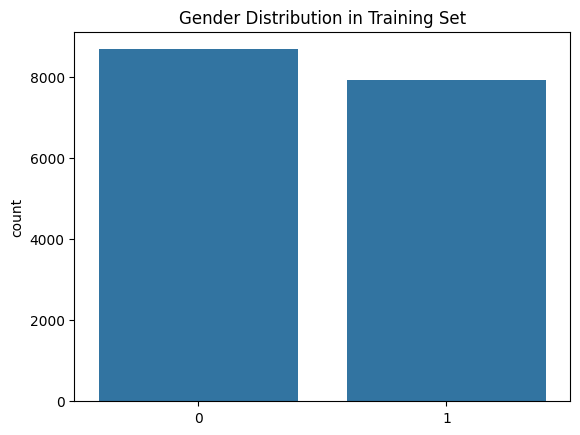

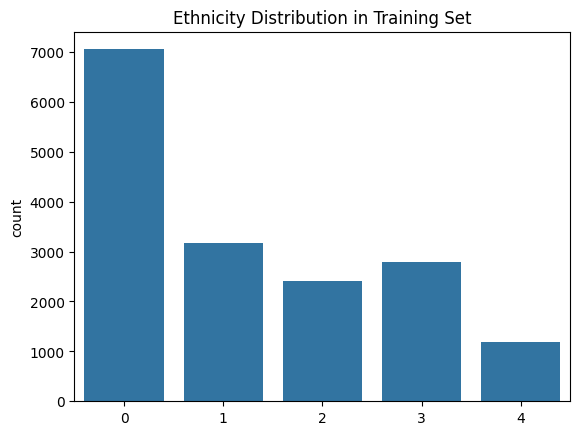

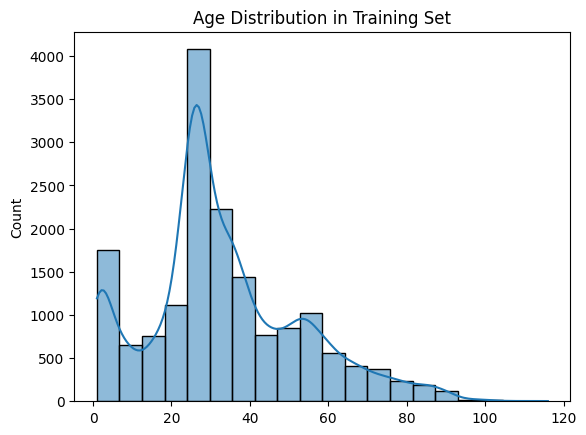

In [14]:
sns.countplot(x=y_gender_train)
plt.title('Gender Distribution in Training Set')
plt.show()

sns.countplot(x=y_ethnicity_train)
plt.title('Ethnicity Distribution in Training Set')
plt.show()

sns.histplot(y_age_train, bins=20, kde=True)
plt.title('Age Distribution in Training Set')
plt.show()

In [17]:
def build_model(input_shape=(48, 48, 1)):
    inputs = Input(shape=input_shape)

    # Shared Convolutional Layers
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Gender Prediction Head
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)

    # Ethnicity Prediction Head
    ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

    # Age Prediction Head
    age_output = Dense(1, activation='linear', name='age')(x)

    # Define the Model
    model = Model(inputs=inputs, outputs=[gender_output, ethnicity_output, age_output])

    return model

# Instantiate the model
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,179,904 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ethnicity (Dense)   │ (None, 5)         │      1,285 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,275,271 (4.86 MB)

 Trainable params: 1,274,823 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)